<a href="https://colab.research.google.com/github/Wafik20/Quantum-Computing-Notes-Code-Samples/blob/main/qml/my_very_first_qnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y pennylane autoray
!pip install "autoray<0.7"
!pip install "pennylane>=0.35,<0.37"

Found existing installation: PennyLane 0.36.0
Uninstalling PennyLane-0.36.0:
  Successfully uninstalled PennyLane-0.36.0
Found existing installation: autoray 0.6.12
Uninstalling autoray-0.6.12:
  Successfully uninstalled autoray-0.6.12
  Using cached autoray-0.6.12-py3-none-any.whl.metadata (5.7 kB)
Using cached autoray-0.6.12-py3-none-any.whl (50 kB)
  Using cached PennyLane-0.36.0-py3-none-any.whl.metadata (9.2 kB)
Using cached PennyLane-0.36.0-py3-none-any.whl (1.7 MB)


In [2]:
import pennylane as qml
import pennylane.numpy as pnp

# 3.2. Quantum machine learning: Variational quantum classifier

## 3.2.1 A Toy 2D Dataset: Half Moons Dataset

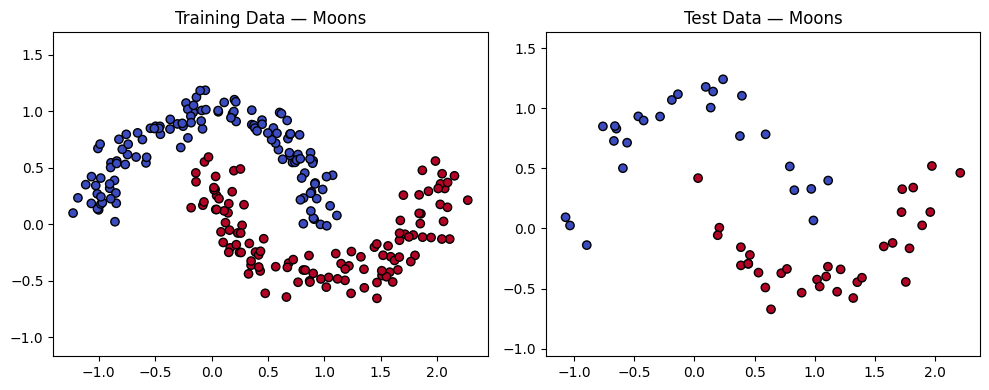

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Two interlocking half-moons
X, y = make_moons(n_samples=300, noise=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.title("Training Data — Moons")
plt.axis('equal')

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.title("Test Data — Moons")
plt.axis('equal')
plt.tight_layout()
plt.show()


$
\textbf{Feature map: } U_{\phi}(\mathbf{x}) = \text{CNOT}_{0 \rightarrow 1} \,
\big( R_X(x_1) \otimes R_X(x_2) \big)
$


In [4]:
dev = qml.device("default.qubit", wires=2) # Default dev with 2 qubits

def feature_map(x):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.CNOT(wires=[0, 1])

# A quick sanity check
@qml.qnode(dev)
def sanity_check(x):
    feature_map(x)
    return qml.expval(qml.PauliZ(0))

mapped_x = [sanity_check(x) for x in X[:5]]
mapped_x

[tensor(0.77569028, requires_grad=True),
 tensor(-0.45305933, requires_grad=True),
 tensor(0.99025064, requires_grad=True),
 tensor(0.63271055, requires_grad=True),
 tensor(0.37865051, requires_grad=True)]

In [5]:
def layer(theta, entangler_parity):
    """
    One VQA layer block:
      - Local SU(2) rotations on both qubits
      - Alternating CNOT entangler (direction flips by layer)

    Args:
        theta (np.ndarray): shape (2, 3) = parameters [ [α_l0, β_l0, γ_l0], [α_l1, β_l1, γ_l1] ]
        entangler_parity (int): layer index parity (0 for even, 1 for odd)
    """
    for i in range(2):  # two qubits
        qml.RZ(theta[i][0], wires=i)
        qml.RY(theta[i][1], wires=i)
        qml.RZ(theta[i][2], wires=i)

    # Alternating entangler
    if entangler_parity % 2 == 0:
        qml.CNOT(wires=[0, 1])
    else:
        qml.CNOT(wires=[1, 0])

In [6]:
@qml.qnode(dev, interface="autograd")
def QNN(params, x):
    theta_layers, beta_out = params
    feature_map(x)
    for l in range(len(theta_layers)):
        layer(theta_layers[l], entangler_parity=l)
    qml.RX(0.1, wires=0)
    qml.RY(beta_out, wires=1)
    return qml.expval(qml.PauliZ(1))

def predict(x, theta_layers, beta_out):
    return (1 + QNN((theta_layers, beta_out), x)) / 2

def bce(y_true, y_pred):
    """Binary cross entropy loss."""
    eps = 1e-9
    return -pnp.mean(y_true * pnp.log(y_pred + eps) + (1 - y_true) * pnp.log(1 - y_pred + eps))

In [7]:
# Initialize parameters
L = 5
theta_layers = pnp.array(
    pnp.random.uniform(0, 2 * pnp.pi, size=(L, 2, 3)),
    requires_grad=True
)

beta_out = pnp.array(
    pnp.random.uniform(0, 2 * pnp.pi),
    requires_grad=True
)

# Using Adam as our optimizer
opt = qml.AdamOptimizer(stepsize=0.02)
n_epochs = 150

for epoch in range(n_epochs):

    batch_idx = pnp.random.choice(len(X_train), size=32, replace=False)

    # Mini batching!!
    def cost_batch(theta_layers, beta_out):
        preds = pnp.stack([predict(X_train[i], theta_layers, beta_out) for i in batch_idx])
        return bce(y_train[batch_idx], preds)

    (theta_layers, beta_out), cost_val = opt.step_and_cost(
        cost_batch, theta_layers, beta_out
    )

    if epoch % 5 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch:03d} | Train Loss = {cost_val:.4f}")

# Eval
y_pred_test = pnp.array([predict(x, theta_layers, beta_out) for x in X_test])
y_class = (y_pred_test > 0.5).astype(int)
accuracy = pnp.mean(y_class == y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Epoch 000 | Train Loss = 0.5037
Epoch 005 | Train Loss = 0.4486
Epoch 010 | Train Loss = 0.3538
Epoch 015 | Train Loss = 0.3504
Epoch 020 | Train Loss = 0.4496
Epoch 025 | Train Loss = 0.3492
Epoch 030 | Train Loss = 0.4523
Epoch 035 | Train Loss = 0.3735
Epoch 040 | Train Loss = 0.3473
Epoch 045 | Train Loss = 0.4104
Epoch 050 | Train Loss = 0.5398
Epoch 055 | Train Loss = 0.4419
Epoch 060 | Train Loss = 0.3119
Epoch 065 | Train Loss = 0.3655
Epoch 070 | Train Loss = 0.4197
Epoch 075 | Train Loss = 0.3843
Epoch 080 | Train Loss = 0.3462
Epoch 085 | Train Loss = 0.4499
Epoch 090 | Train Loss = 0.4410
Epoch 095 | Train Loss = 0.3422
Epoch 100 | Train Loss = 0.4246
Epoch 105 | Train Loss = 0.3122
Epoch 110 | Train Loss = 0.3425
Epoch 115 | Train Loss = 0.3307
Epoch 120 | Train Loss = 0.4167
Epoch 125 | Train Loss = 0.3227
Epoch 130 | Train Loss = 0.4200
Epoch 135 | Train Loss = 0.4585
Epoch 140 | Train Loss = 0.3446
Epoch 145 | Train Loss = 0.3258
Epoch 149 | Train Loss = 0.4817
Accuracy

**Reported Accuracy = 91.67%**